In [3]:
import numpy as np
import sys
sys.path.append('../')
from symmetry_breaking_measure import Nickel, RotationOperator
import matplotlib.pyplot as plt
from bg_mpl_stylesheet.bg_mpl_stylesheet import bg_mpl_style
from colour import Color
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.image import imread
from matplotlib import rc
from tqdm import tqdm
from typing import Tuple
from multiprocessing import Pool, cpu_count
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

def make_Ramp(ramp_colors): 
    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    return color_ramp

BLUE, RED, YELLOW, MIDDLE = '#0B3C5D', '#B82601', '#D9B310', '#a8b6c1'
axis = [0,0,1]
angles = np.linspace(0, 360, 361)

NUM_SAMPLES = 50000
CONFIDENCE_LEVEL = .95
TOLERANCE_ONE_SIDE = .025

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The symmetry breaking from the boundary of the finite cluster

In [4]:
def calc_variance_sample_size_from_nickel(nickel_structure, op, **operator_kwrgs):
    sample_size, measure = nickel_structure.calc_symmetry_breaking_measure_sample_size(
        num_samples=NUM_SAMPLES,
        operator=op,
        confidence_interval=CONFIDENCE_LEVEL,
        tolerance_single_side=TOLERANCE_ONE_SIDE,
        method='KL',
        **operator_kwrgs
        )
    return measure, sample_size

def compute_sbm(args):
    nickel_structure, rotation_op, angle = args
    return nickel_structure.calc_symmetry_breaking_measure(
            num_samples=calc_variance_sample_size_from_nickel(nickel_structure, rotation_op, angle=angle)[1],
            operator=rotation_op, 
            method='KL', 
            angle=angle
        )
    
def construct_tasks_sample_size(nickel_structure):
    origin = nickel_structure.xyz.mean(axis=0)
    rotation_op = RotationOperator(axis=axis, origin=origin)
    tasks = [(nickel_structure, rotation_op, angle) for angle in tqdm(angles, desc="Creating tasks")]
    return tasks

def test_symmetry_breaking_measure(
    nickel_structure,
    save_filedir: str = None
):
    tasks = construct_tasks_sample_size(nickel_structure)
    with Pool(processes=cpu_count()) as pool:
        measures = list(tqdm(pool.imap(compute_sbm, tasks), total=len(tasks)))
    measures_data = np.column_stack((angles, measures))
    if save_filedir:
        np.savetxt(save_filedir, measures_data, delimiter=',') 
    return measures_data

def plot_symmetry_breaking_measure(
    measures_data: np.ndarray,
    fig_size: Tuple[int, int],
    color: str,
    min_color: str,
    style: str = "default",
    save_filedir: str = None
):
    plt.style.use(style)
    rc('text', usetex = True) 
    params= {'text.latex.preamble' : r'\usepackage{mathrsfs}'}
    plt.rcParams.update(params)
    angles, measures = measures_data[:, 0], measures_data[:, 1]
    measures_round = np.round(measures, 5)
    min_idx = np.where(measures_round == np.amin(measures_round))[0]
    fig, ax = plt.subplots(figsize=fig_size)
    ax.plot(angles, measures, color=color)
    for idx in min_idx:
        ax.axvline(x=angles[int(idx)], color=min_color, linestyle="--")
    ax.set_ylabel(r'$\mathscr{S}^{KL}_{R_\alpha}$')
    ax.set_xlabel(r'$\alpha$ (degree)')
    ax.set_xlim([0,360])
    plt.show()
    if save_filedir:
        fig.savefig(save_filedir)

  0%|          | 0/361 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/diffpy-cmi/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/diffpy-cmi/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 361/361 [00:06<00:00, 53.08it/s]


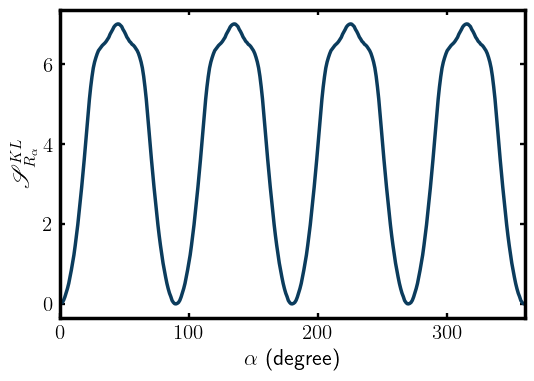

In [3]:
# Spheroid cut off from Nickel (radius=1)
spheroid_nickel = Nickel(cutoff='ellipsoid', cutout_x=1, cutout_y=1, cutout_z=1)
save_filedir = '../figs/nickel/spheroid_nickel_rotation_KL.csv'
fig_directory = '../figs/nickel/spheroid_nickel_rotation_KL.png'
measures_data = test_symmetry_breaking_measure(spheroid_nickel, save_filedir=save_filedir)
plot_symmetry_breaking_measure(measures_data, fig_size=(6,4), color=BLUE, min_color=RED, style=bg_mpl_style, save_filedir=fig_directory)

  0%|          | 0/361 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/diffpy-cmi/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/diffpy-cmi/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 361/361 [04:26<00:00,  1.35it/s]


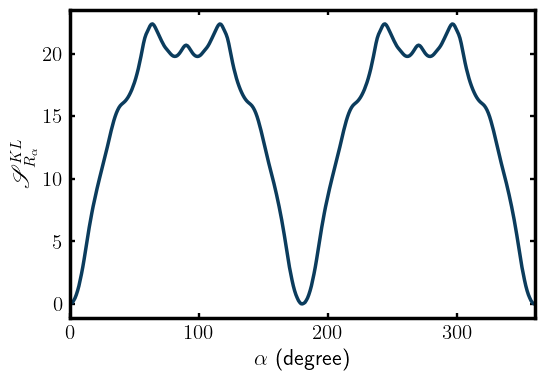

In [6]:
# Ellipsoid cut off from Nickel
ellipsoid_nickel = Nickel(cutoff='ellipsoid', cutout_x=2, cutout_y=1, cutout_z=1)
save_filedir = '../figs/nickel/ellipsoid_nickel_rotation_KL.csv'
fig_directory = '../figs/nickel/ellipsoid_nickel_rotation_KL.png'
measures_data = test_symmetry_breaking_measure(ellipsoid_nickel, save_filedir=save_filedir)
plot_symmetry_breaking_measure(measures_data, fig_size=(6,4), color=BLUE, min_color=RED, style=bg_mpl_style, save_filedir=fig_directory)

  0%|          | 0/361 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/diffpy-cmi/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/diffpy-cmi/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 361/361 [00:07<00:00, 49.88it/s]


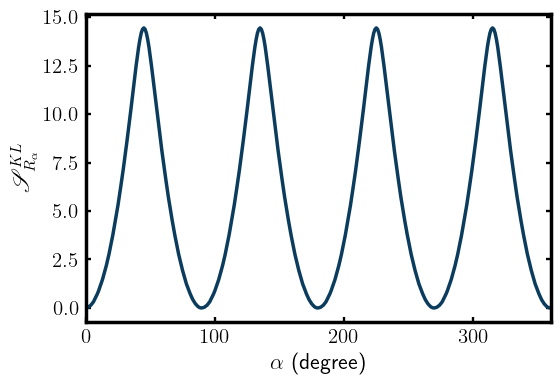

In [3]:
# Cubic cut off from Nickel (length=1)
cubic_nickel = Nickel(cutoff='rectangular_solid', cutout_x=1, cutout_y=1, cutout_z=1)
save_filedir = '../figs/nickel/cubic_solid_nickel_rotation_KL.csv'
fig_directory = '../figs/nickel/cubic_solid_nickel_rotation_KL.png'
measures_data = test_symmetry_breaking_measure(cubic_nickel, save_filedir=save_filedir)
plot_symmetry_breaking_measure(measures_data, fig_size=(6,4), color=BLUE, min_color=RED, style=bg_mpl_style, save_filedir=fig_directory)

  0%|          | 0/361 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/diffpy-cmi/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/diffpy-cmi/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 361/361 [00:45<00:00,  7.95it/s]


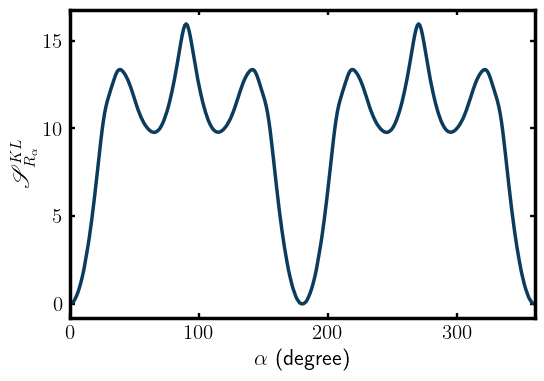

In [5]:
# Rectangular cut off from Nickel
rectangular_solid_nickel = Nickel(cutoff='rectangular_solid', cutout_x=2, cutout_y=1, cutout_z=1)
save_filedir = '../figs/nickel/rectangular_solid_nickel_rotation_KL.csv'
fig_directory = '../figs/nickel/rectangular_solid_nickel_rotation_KL.png'
measures_data = test_symmetry_breaking_measure(rectangular_solid_nickel, save_filedir=save_filedir)
plot_symmetry_breaking_measure(measures_data, fig_size=(6,4), color=BLUE, min_color=RED, style=bg_mpl_style, save_filedir=fig_directory)

# Paper Section 5.1.1

In [6]:
def plot_compare(x, y1, y2, xlim: list, ylim: list, xlabel, ylabel, subfigs_info: dict, text: dict, fig_size: Tuple[int, int], style: str = "default", save_filedir=None):
    fig = plt.figure()
    fig.set_size_inches(fig_size[0],fig_size[1])
    plt.style.use(style)
    
    ax_main = fig.add_subplot()
    ax_main.plot(x, y1, color=BLUE, alpha=.85)
    ax_main.plot(x, y2, color=RED, alpha=.85)
    ax_main.set_xlim(xlim)
    ax_main.set_ylim(ylim)
    
    rc('text', usetex = True) 
    params= {'text.latex.preamble' : r'\usepackage{mathrsfs}'}
    plt.rcParams.update(params)
    ax_main.set_xlabel(xlabel)
    ax_main.set_ylabel(ylabel)
    
    for key, value in subfigs_info.items():
        img = imread(key)
        ax_spheroid = fig.add_axes(value)
        ax_spheroid.imshow(img)
        ax_spheroid.set_axis_off()
        
    ax_text = fig.add_axes(text['loc'])
    ax_text.text(0, 0, text['content'])
    ax_text.set_axis_off()
        
    plt.show()
    if save_filedir:
        fig.savefig(save_filedir)

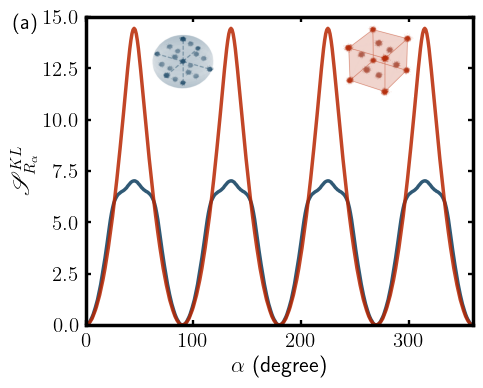

In [7]:
# spheroid and cubic solid
spheroid_filedir = '../figs/nickel/spheroid_nickel_rotation_KL.csv'
cubic_filedir = '../figs/nickel/cubic_solid_nickel_rotation_KL.csv'
save_filedir = '../figs/nickel/rotation_spheroid_vs_cubic_solid_KL.png'
spheroid_measures_data = np.loadtxt(spheroid_filedir, delimiter=',')
cubic_measures_data = np.loadtxt(cubic_filedir, delimiter=',')
plot_compare(x=spheroid_measures_data[:,0], y1=spheroid_measures_data[:,1], y2=cubic_measures_data[:,1],
             xlim=[angles[0], angles[-1]], ylim=[0,15], xlabel=r'$\alpha$ (degree)', ylabel=r'$\mathscr{S}^{KL}_{R_\alpha}$',
             subfigs_info={'../figs/nickel/spheroid_nickel_samples_nobackground.png': [0.24, 0.69, 0.16, 0.16],
                           '../figs/nickel/cubic_solid_nickel_samples_nobackground.png': [0.62, 0.68, 0.18, 0.18]},
             text={'content':'(a)', 'loc':[-0.02, .85, 0, 0]}, 
             fig_size=(5,4), style=bg_mpl_style, save_filedir=save_filedir)

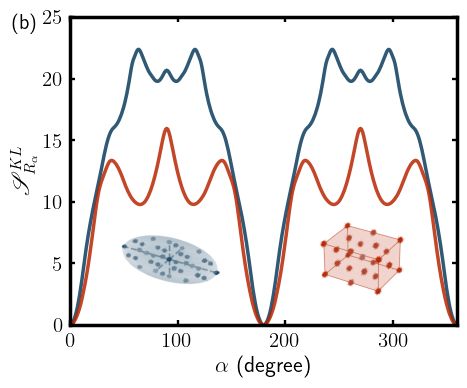

In [8]:
# ellipsoid and rectangular solid
ellipsoid_filedir = '../figs/nickel/ellipsoid_nickel_rotation_KL.csv'
rectangular_filedir = '../figs/nickel/rectangular_solid_nickel_rotation_KL.csv'
save_filedir = '../figs/nickel/rotation_ellipsoid_vs_rectangular_solid_KL.png'
ellipsoid_measures_data = np.loadtxt(ellipsoid_filedir, delimiter=',')
rectangular_measures_data = np.loadtxt(rectangular_filedir, delimiter=',')
plot_compare(x=ellipsoid_measures_data[:,0], y1=ellipsoid_measures_data[:,1], y2=rectangular_measures_data[:,1],
             xlim=[angles[0], angles[-1]], ylim=[0,25], xlabel=r'$\alpha$ (degree)', ylabel=r'$\mathscr{S}^{KL}_{R_\alpha}$',
             subfigs_info={'../figs/nickel/ellipsoid_nickel_samples_nobackground.png': [0.20, 0.15, 0.25, 0.25],
                           '../figs/nickel/rectangular_solid_nickel_samples_nobackground.png': [0.60, 0.17, 0.22, 0.22]},
             text={'content':'(b)', 'loc':[0.01, .85, 0, 0]}, 
             fig_size=(5,4), style=bg_mpl_style, save_filedir=save_filedir)

In [6]:
sum = 0
for angle in [90, 180, 270]:
    print(ellipsoid_measures_data[angle,:])
    sum += ellipsoid_measures_data[angle,1]
print(sum/3)

[90.        20.8964235]
[1.80000000e+02 9.00162848e-18]
[270.         20.8964235]
13.93094899923461


In [5]:
sum = 0
for angle in [90, 180, 270]:
    print(rectangular_measures_data[angle,:])
    sum += rectangular_measures_data[angle,1]
print(sum/3)

[90.         16.12563481]
[ 1.80000000e+02 -1.64976465e-18]
[270.          16.12563481]
10.75042320718777
